In [1]:
%reset -sf

from time import time
time_start = time()

import pandas as pd
import numpy as np
import scipy as sp
import gc
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # suppress tensorflow imformation messages

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold

import tensorflow as tf

import get_data as gd
import atlas_plot as ap
plot = ap.Plotter()

print(tf.__version__)
print(tf.config.list_physical_devices())
print()

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]



In [2]:
seed = 42  # set random seed
sampling = int(2e5)
num_folds = 8
batch_size = 512
epochs = 256
learning_rate = 1e-4

In [3]:
np.random.seed(seed)
processor = gd.DataProcessor(sampling=sampling, processor=10)
path = "/root/data/truth/signal/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 10

['/root/data/truth/signal/CGLMP.npz', '/root/data/truth/signal/Higgs.npz', '/root/data/truth/signal/LeadLepton.npz', '/root/data/truth/signal/LeptonM.npz', '/root/data/truth/signal/LeptonP.npz', '/root/data/truth/signal/LmNu.npz', '/root/data/truth/signal/LpNu.npz', '/root/data/truth/signal/MET.npz', '/root/data/truth/signal/WmBoson.npz', '/root/data/truth/signal/WpBoson.npz', '/root/data/truth/signal/diLepton.npz', '/root/data/truth/signal/subLeadLepton.npz', '/root/data/truth/signal/xi_xyz.npz']



In [4]:
GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV
cut_pre = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss

del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

In [5]:
# inputs -> observed params
lep_p = processor.process_part(data.LepP)[cut_pre]
lep_m = processor.process_part(data.LepM)[cut_pre]
lep_kin = pd.concat([lep_p, lep_m], axis=1)
MET = processor.process_MET(data.MET).iloc[:, 1:3][cut_pre]
obs_kin = pd.concat([MET, lep_kin], axis=1)
print("obs_kin shape:", obs_kin.shape)
print(obs_kin.head(3))
print()

# targets -> interested unknowns
int_kin = pd.DataFrame(
    processor.process_dipart(data.LepP, data.LepM)[["E", "pz"]][cut_pre]
)
print("int_kin shape:", int_kin.shape)
print(int_kin.head(3))
print()

del (processor, lep_p, lep_m, MET)
gc.collect()

obs_kin shape: (93561, 10)
      MET_px     MET_py           E         px         py         pz  \
1 -15.338361  14.172350   15.245948  18.318031   6.277000  83.935484   
4  -6.146207  -7.604162  196.946359 -15.254316  19.465705 -43.854508   
5  -9.971150 -18.844210   40.562547  -0.665311  13.625138  -0.769002   

            E         px         py         pz  
1   81.421758 -17.298279  -9.242714  14.035491  
4  585.067500  23.439492   9.261659  -2.846227  
5    7.339792  10.357368  50.716391  72.101703  

int_kin shape: (93561, 2)
            E         pz
1   96.667706  97.970976
4  782.013859 -46.700735
5   47.902339  71.332701



0

In [6]:
SCALAR_int = StandardScaler()
int_kin = SCALAR_int.fit_transform(int_kin)

SCALAR_obs = StandardScaler()
obs_kin = SCALAR_obs.fit_transform(obs_kin)

indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, test_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.8,
    test_size=0.2,
    random_state=seed,
    shuffle=True,
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
train_y = int_kin[train_indices]
test_y = int_kin[test_indices]

print(f"X:\nTraining data shape: {train_x.shape};\nTesting data shape: {test_x.shape}.")
print(f"Y:\nTraining data shape: {train_y.shape};\nTesting data shape: {test_y.shape}.")
print()

X:
Training data shape: (74848, 10);
Testing data shape: (18713, 10).
Y:
Training data shape: (74848, 2);
Testing data shape: (18713, 2).



In [7]:
# Define the generator function of the dataset.
def data_gen(X_data, y_data, indices):
    while True:
        for start in range(0, len(indices), batch_size):
            end = min(start + batch_size, len(indices))
            # print(f"start: {start}, end: {end}, indices: {indices[start:end]}")
            # print(f"X_data shape: {X_data.shape}, y_data shape: {y_data.shape}")
            yield X_data[indices[start:end]], y_data[indices[start:end]]

In [8]:
# Define the model.
def build_model():
    model = tf.keras.models.Sequential()

    # Input layer
    model.add(tf.keras.layers.Flatten(input_shape=(train_x.shape[-1],)))

    # Hidden tf.keras.layers
    model.add(tf.keras.layers.Dense(units=8, activation="relu"))
    model.add(tf.keras.layers.Dense(units=8, activation="relu"))
    model.add(tf.keras.layers.Dense(units=4, activation="relu"))
    model.add(tf.keras.layers.Dense(units=4, activation="relu"))

    # Last dense layer
    model.add(tf.keras.layers.Dense(units=2, activation="linear"))

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=["accuracy"],
    )

    return model

Training for fold 1 ...
Score for fold 1: loss of 0.00010360618034610525; accuracy of 99.75416660308838%
Plotting fold 1 loss history...


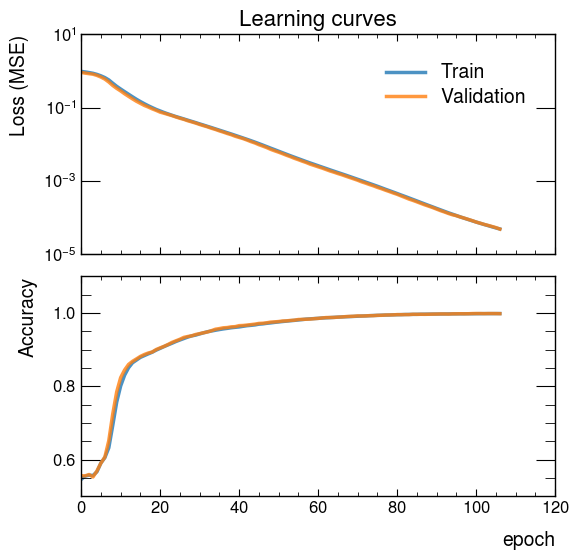

Training for fold 2 ...
Score for fold 2: loss of 0.0001490909344283864; accuracy of 99.67935085296631%
Plotting fold 2 loss history...


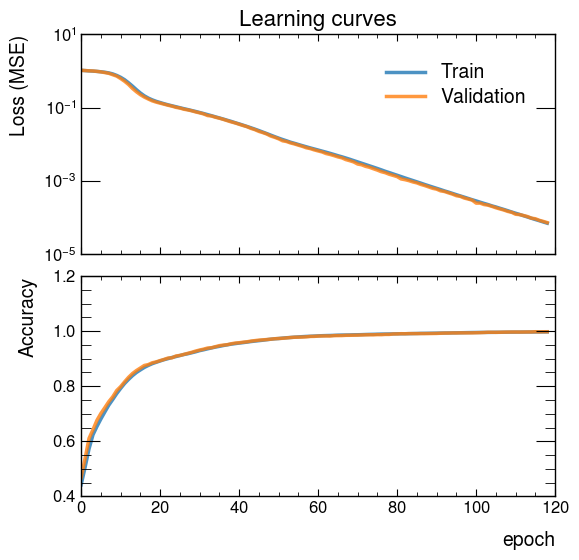

Training for fold 3 ...
Score for fold 3: loss of 0.00017554890655446798; accuracy of 99.94655847549438%
Plotting fold 3 loss history...


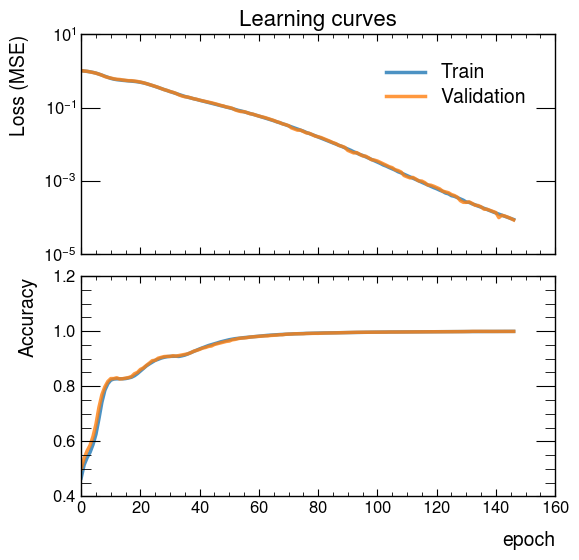

Training for fold 4 ...
Score for fold 4: loss of 0.0023083086125552654; accuracy of 99.26250576972961%
Plotting fold 4 loss history...


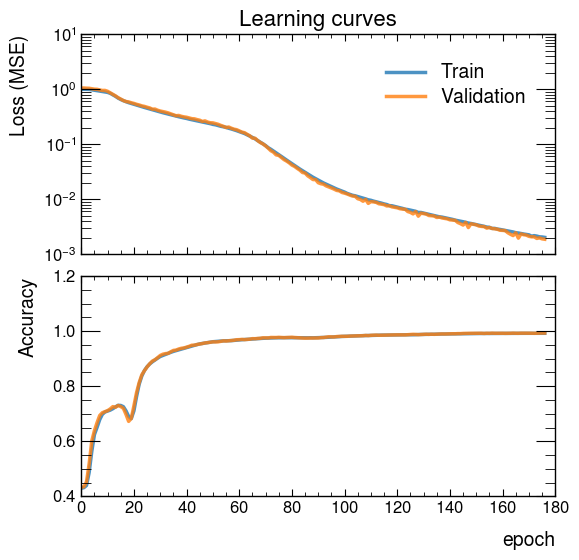

Training for fold 5 ...
Score for fold 5: loss of 0.00017070288595277816; accuracy of 99.63659644126892%
Plotting fold 5 loss history...


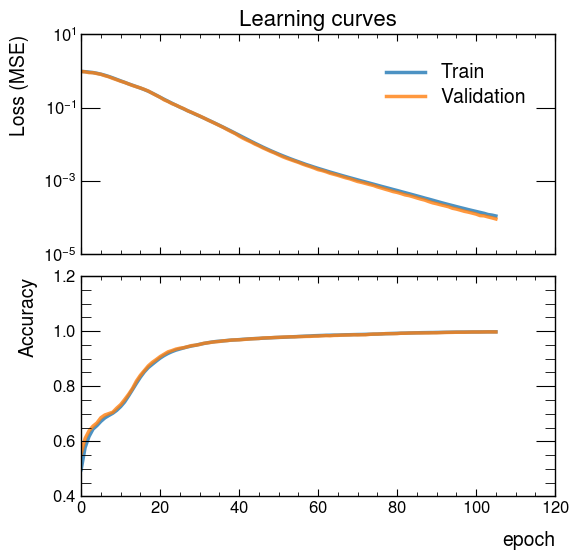

Training for fold 6 ...
Score for fold 6: loss of 0.00022631656611338258; accuracy of 99.67935085296631%
Plotting fold 6 loss history...


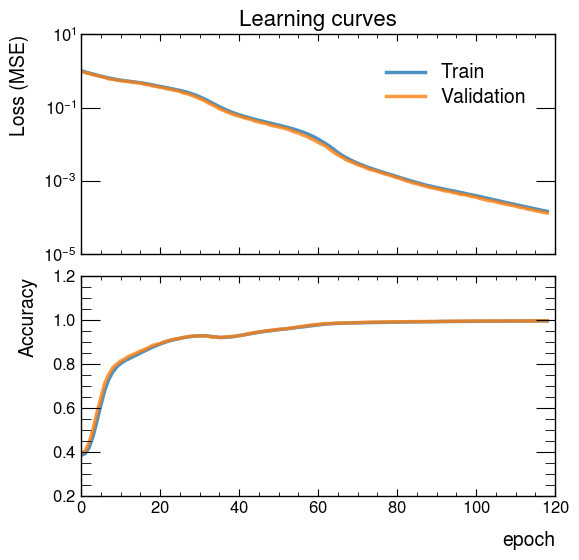

Training for fold 7 ...
Score for fold 7: loss of 0.00014448905130848289; accuracy of 99.77554678916931%
Plotting fold 7 loss history...


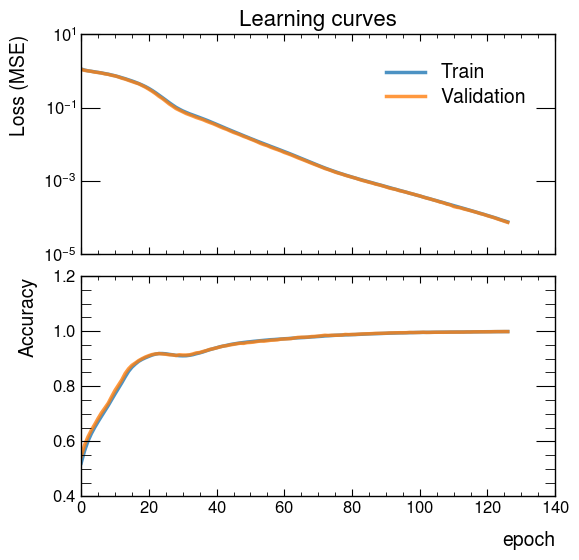

Training for fold 8 ...
Score for fold 8: loss of 0.0001281407749047503; accuracy of 99.67935085296631%
Plotting fold 8 loss history...


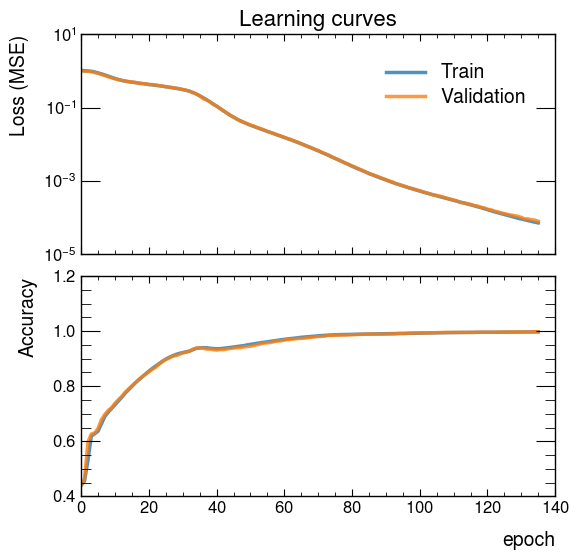

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 8)                 88        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 4)                 20        
                                                                 
 dense_4 (Dense)             (None, 2)                 10        
                                                                 
Total params: 226 (904.00 Byte)
Trainable params: 226 (9

In [9]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
best_model = None
best_loss = np.inf

# Settting up early stopping callbacks
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=10,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

# Check and find the best model form k-fold cross validation (or detect wether it's overtrining or not).
for train, valid in kfold.split(train_x, train_y):
    # Define the model architecture
    model = build_model()

    # Generate a print
    print(f"Training for fold {fold_no} ...")

    # Fit the model
    history = model.fit(
        data_gen(train_x, train_y, train),
        steps_per_epoch=len(train) // batch_size,
        validation_data=data_gen(train_x, train_y, valid),
        validation_steps=len(valid) // batch_size,
        epochs=epochs,
        verbose=0,
        callbacks=[stop_early],
    )

    # Generate generalization metrics
    scores = model.evaluate(train_x[valid], train_y[valid], verbose=0)
    print(
        f"Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%"
    )
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Check if this model is better than the previous best model
    if scores[0] < best_loss:
        best_loss = scores[0]
        best_model = model
        best_history = history

    # Plotting training results
    print(f"Plotting fold {fold_no} loss history...")
    plot.plot_loss_history(history, logy=True)

    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
best_model.summary()
print(
    f"""{'-'*72}
Score per fold"""
)
for i in range(0, len(acc_per_fold)):
    print(
        f"""{'-'*72}
> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%"""
    )
print(
    f"""{'-'*72}
Average scores for all folds:
> Accuracy: {np.mean(acc_per_fold)}% (+- {np.std(acc_per_fold)})
> Loss: {np.mean(loss_per_fold)}
{'-'*72}"""
)

In [10]:
# save model
best_model.save("DNN_kfolds.h5", save_format="h5", overwrite=True)
# predict
pred_y = best_model.predict(test_x)
sig_pred = pred_y
sig_truth = test_y

 41/585 [=>............................] - ETA: 0s 

/root/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


585/585 [==============================] - 1s 1ms/step


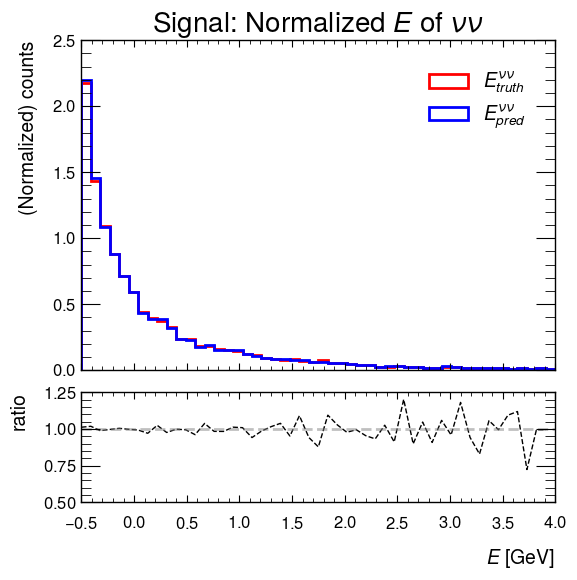

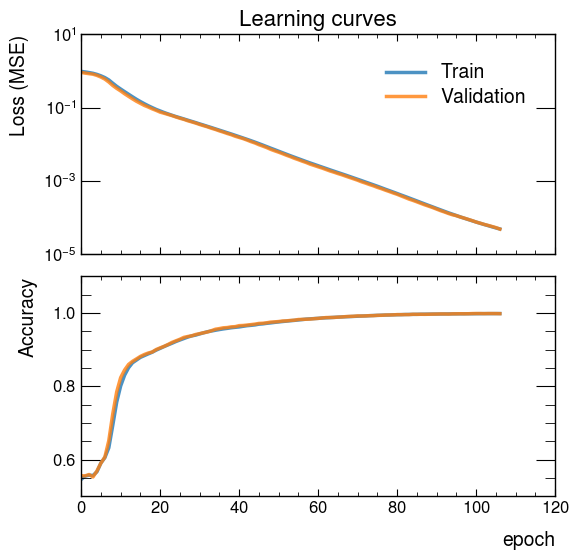

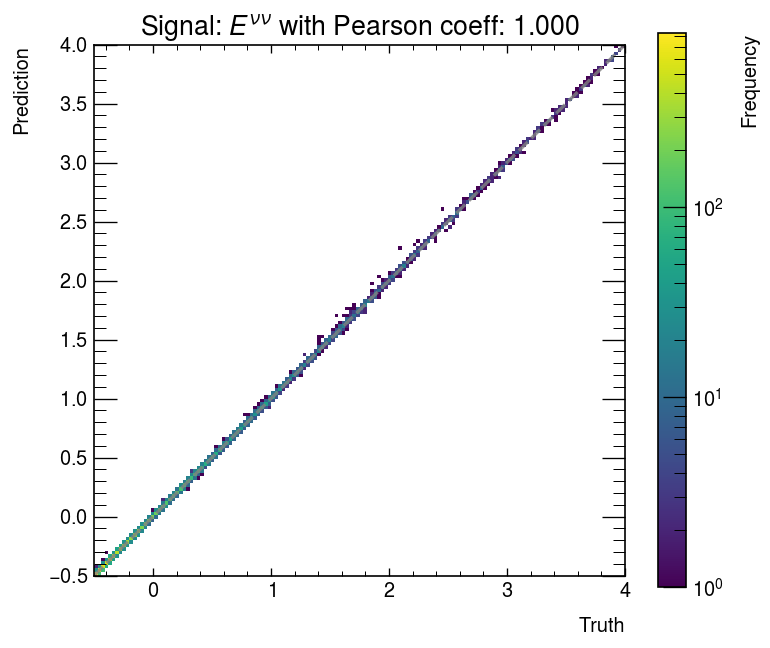

In [11]:
range = [-0.5, 4]

plot.plot_hist(
    [sig_truth[:, 0], sig_pred[:, 0]],
    [r"$E_{truth}^{\nu\nu}$", r"$E_{pred}^{\nu\nu}$"],
    r"Signal: Normalized $E$ of $\nu\nu$",
    range=range,
    xlabel=r"$E$ [GeV]",
)

plot.plot_loss_history(best_history, logy=True)

plot.plot_2d_histogram(
    sig_pred[:, 0],
    sig_truth[:, 0],
    "Signal: "
    + r"$E^{\nu\nu}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth[:,0], sig_pred[:,0])[0]:.3f}",
    range=range,
)

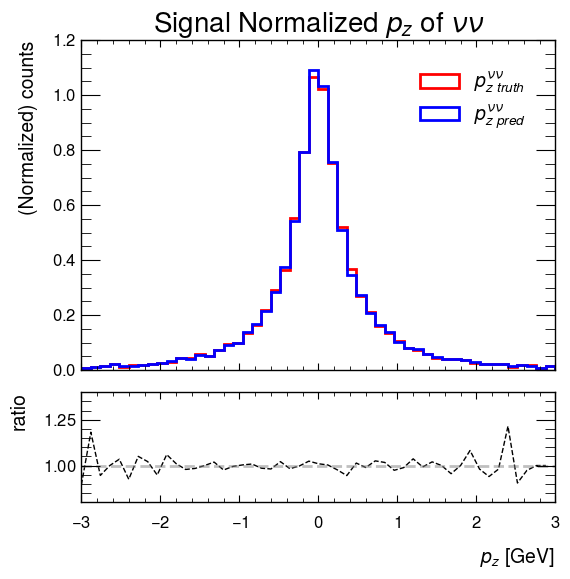

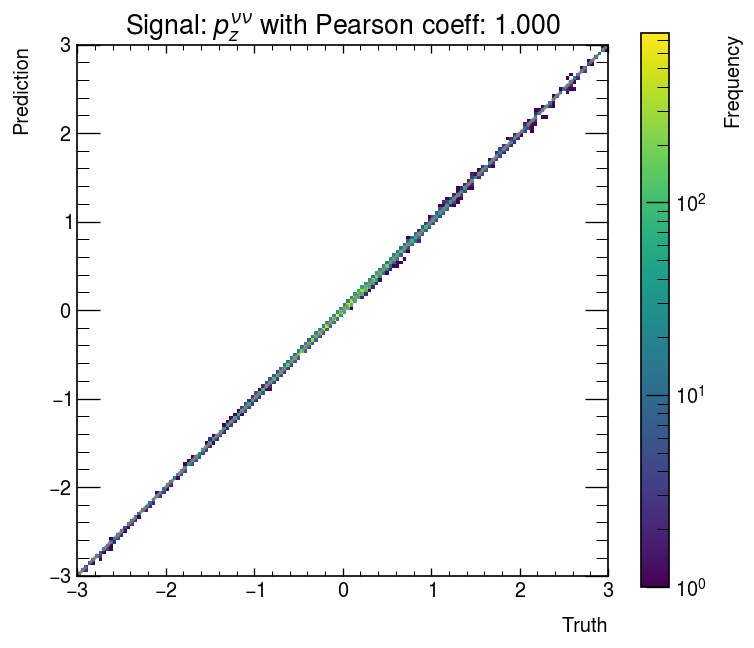

In [12]:
range = [-3, 3]

plot.plot_hist(
    [sig_truth[:, 1], sig_pred[:, 1]],
    [r"$p_{z\ truth}^{\nu\nu}$", r"$p_{z\ pred}^{\nu\nu}$"],
    r"Signal Normalized $p_{z}$ of $\nu\nu$",
    range=range,
    xlabel=r"$p_{z}$ [GeV]",
)

plot.plot_2d_histogram(
    sig_truth[:, 1],
    sig_pred[:, 1],
    r"Signal: $p_{z}^{\nu\nu}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth[:,1], sig_pred[:,1])[0]:.3f}",
    range=range,
)

In [13]:
# Background
processor = gd.DataProcessor(sampling=sampling, processor=10)
path = "/root/data/truth/background/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 10

['/root/data/truth/background/CGLMP.npz', '/root/data/truth/background/Higgs.npz', '/root/data/truth/background/LeadLepton.npz', '/root/data/truth/background/LeptonM.npz', '/root/data/truth/background/LeptonP.npz', '/root/data/truth/background/LmNu.npz', '/root/data/truth/background/LpNu.npz', '/root/data/truth/background/MET.npz', '/root/data/truth/background/WmBoson.npz', '/root/data/truth/background/WpBoson.npz', '/root/data/truth/background/diLepton.npz', '/root/data/truth/background/subLeadLepton.npz', '/root/data/truth/background/xi_xyz.npz']



In [14]:
# inputs -> observed params
lep_p = processor.process_part(data.LepP)[cut_pre]
lep_m = processor.process_part(data.LepM)[cut_pre]
lep_kin = pd.concat([lep_p, lep_m], axis=1)
MET = processor.process_MET(data.MET).iloc[:, 1:3][cut_pre]
obs_kin = pd.concat([MET, lep_kin], axis=1)
print("obs_kin shape:", obs_kin.shape)
print(obs_kin.head(3))
print()

# targets -> interested unknowns
int_kin = pd.DataFrame(
    processor.process_dipart(data.LepP, data.LepM)[["E", "pz"]][cut_pre]
)
print("int_kin shape:", int_kin.shape)
print(int_kin.head(3))
print()

del (processor, lep_p, lep_m, MET)
gc.collect()

obs_kin shape: (93561, 10)
       MET_px      MET_py           E         px         py          pz  \
1   85.074713  -94.894906   31.148197  -8.938045 -83.988008 -213.316109   
4 -101.361387  112.734579   31.977082  11.986140  59.227191    3.195748   
5   31.026371   -8.951367  573.844687  -2.495304  -8.879060  -59.843664   

           E         px         py          pz  
1  29.870363 -68.178609  17.443730 -647.819375  
4  30.541406  23.421076  71.565711   28.173504  
5  22.750127 -23.603236  13.852211  -31.563012  

int_kin shape: (93561, 2)
            E          pz
1   61.018561 -861.135484
4   62.518488   31.369252
5  596.594814  -91.406676



70743

In [15]:
SCALAR_int_bkg = StandardScaler()
int_kin = SCALAR_int.fit_transform(int_kin)

SCALAR_obs_bkg = StandardScaler()
obs_kin = SCALAR_obs.fit_transform(obs_kin)

x, y = obs_kin[indices_arr], int_kin[indices_arr]

print(f"X:\ndata shape: {x.shape};\nY:\ndata shape: {y.shape}.")
print()

X:
data shape: (93561, 10);
Y:
data shape: (93561, 2).



In [16]:
y_pred = best_model.predict(x)
bkg_pred = y_pred
bkg_truth = y

2924/2924 [==============================] - 3s 1ms/step


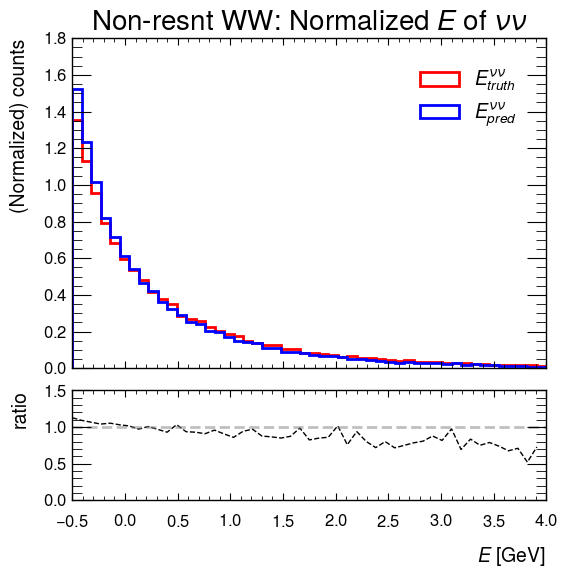

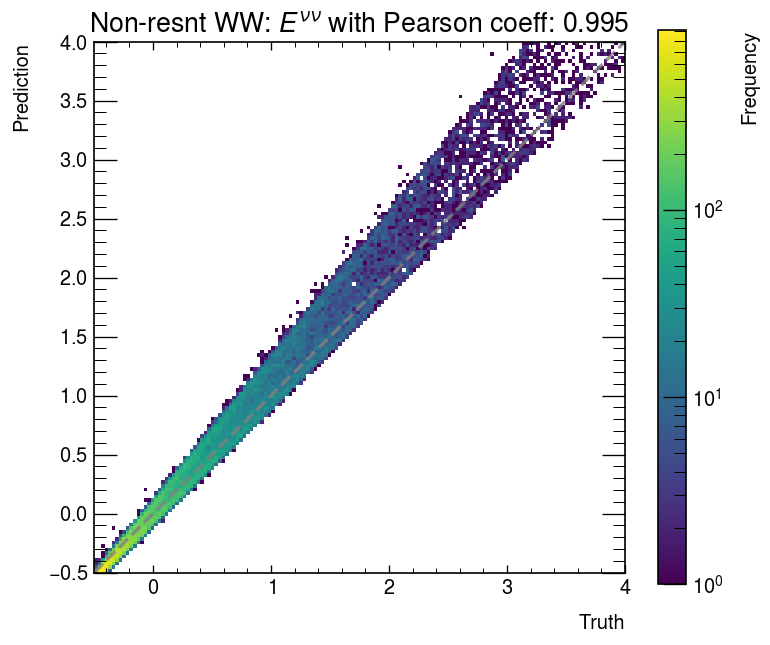

In [17]:
range = [-0.5, 4]

plot.plot_hist(
    [bkg_truth[:, 0], bkg_pred[:, 0]],
    [r"$E_{truth}^{\nu\nu}$", r"$E_{pred}^{\nu\nu}$"],
    "Non-resnt WW: " + r"Normalized $E$ of $\nu\nu$",
    range=range,
    xlabel=r"$E$ [GeV]",
)

plot.plot_2d_histogram(
    bkg_pred[:, 0],
    bkg_truth[:, 0],
    "Non-resnt WW: "
    + r"$E^{\nu\nu}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(bkg_truth[:,0], bkg_pred[:,0])[0]:.3f}",
    range=range,
)

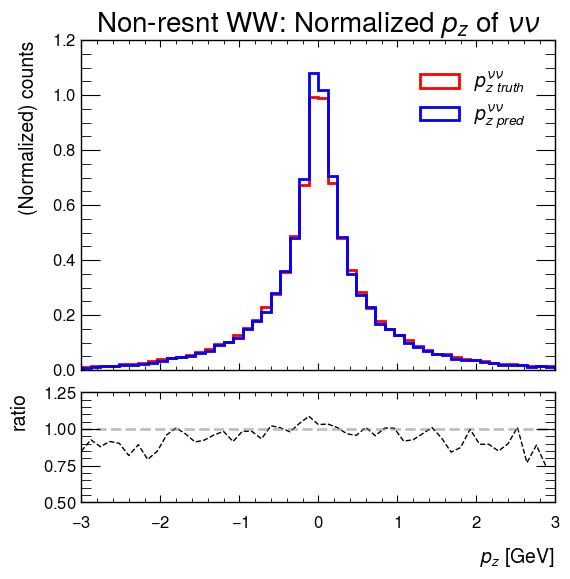

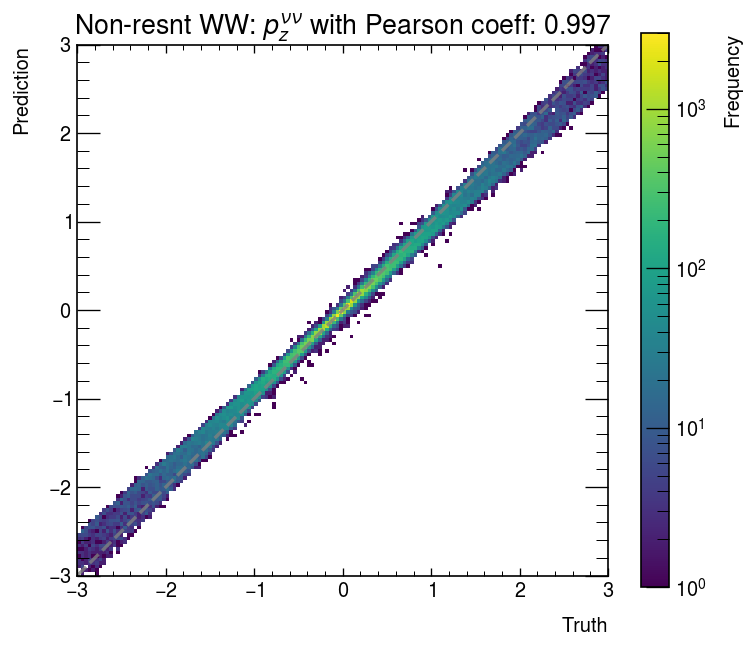

Time cost: 578.26 s.


In [18]:
range = [-3, 3]

plot.plot_hist(
    [bkg_truth[:, 1], bkg_pred[:, 1]],
    [r"$p_{z\ truth}^{\nu\nu}$", r"$p_{z\ pred}^{\nu\nu}$"],
    r"Non-resnt WW: Normalized $p_{z}$ of $\nu\nu$",
    range=range,
    xlabel=r"$p_{z}$ [GeV]",
)

plot.plot_2d_histogram(
    bkg_truth[:, 1],
    bkg_pred[:, 1],
    "Non-resnt WW: "
    + r"$p_{z}^{\nu\nu}$"
    + f" with Pearson coeff: {sp.stats.pearsonr(bkg_truth[:,1], bkg_pred[:,1])[0]:.3f}",
    range=range,
)

time_end = time()
print(f"Time cost: {(time_end - time_start):.2f} s.")